# EYE FOR BLIND
**Problem statement:** In this capstone project, you need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library.

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.

The project is an extended application of **Show, Attend and Tell: Neural Image Caption Generation with Visual Attention paper.**

The dataset is taken from the Kaggle website and it consists of sentence-based image descriptions having a list of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events of the image.

In [1]:
# Import all the required libraries
!pip install gTTs

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import string
from collections import Counter
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
from gtts import gTTS
from IPython.display import Audio, display
from PIL import Image
import math
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_colwidth',100)

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions

In [2]:
# Import the dataset and read the image into a seperate variable

images_path = 'datasets/flickr/Images/'

all_imgs = glob.glob(images_path + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [3]:
# Import the dataset and read the text file into a seperate variable
captions_path ='datasets/flickr/captions.txt'

image_captions_df = pd.read_csv(captions_path)
image_captions_df.head(20)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


**Observation on the Text Dataset**
-  **Multiple Captions per Image**
    -  Each image has five different captions, providing semantic variety and multiple human perspectives.
    -  Example: **1000268201_693b08cb0e.jpg** has 5 captions describing the same scene (a girl climbing stairs into a wooden structure), each with different wording and focus.

-  **Image ID as Unique Key**
  -  The column image serves as a unique identifier for each photo.

  -  It's used to group captions and map them to the correct image file.

-  **Descriptive and Natural Language**
  -  Captions are written in natural language, often complete sentences.

  -  They describe visual elements, actions, and sometimes colors, emotions, or scene context.

-  **Useful for Image Captioning Tasks**
  -  This format is ideal for training and evaluating image captioning models (e.g., CNN+RNN or transformer-based models).

  -  The multiple captions per image allow models to learn semantic richness and language variation.

-  **Consistent Structure**
  -  The dataset appears to be well-structured, with clear mapping between images and their descriptions.

  -  Captions are cleanly formatted, which is great for preprocessing without much cleaning effort.

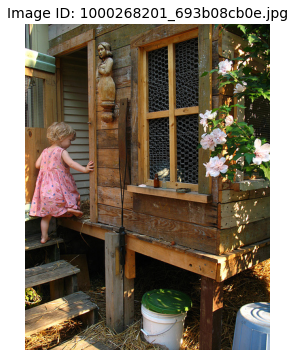

Image Shape: (500, 375, 3)

Captions for the Image ID "1000268201_693b08cb0e.jpg":
1. A child in a pink dress is climbing up a set of stairs in an entry way .
2. A girl going into a wooden building .
3. A little girl climbing into a wooden playhouse .
4. A little girl climbing the stairs to her playhouse .
5. A little girl in a pink dress going into a wooden cabin .




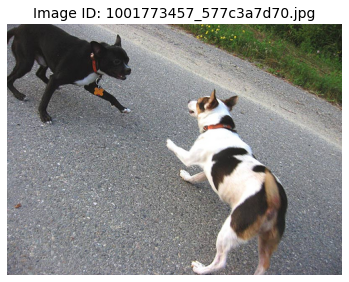

Image Shape: (375, 500, 3)

Captions for the Image ID "1001773457_577c3a7d70.jpg":
1. A black dog and a spotted dog are fighting
2. A black dog and a tri-colored dog playing with each other on the road .
3. A black dog and a white dog with brown spots are staring at each other in the street .
4. Two dogs of different breeds looking at each other on the road .
5. Two dogs on pavement moving toward each other .




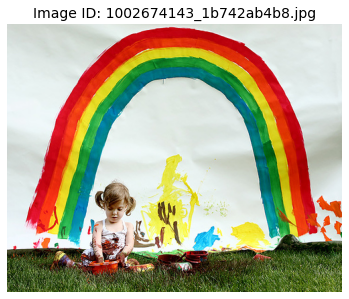

Image Shape: (400, 500, 3)

Captions for the Image ID "1002674143_1b742ab4b8.jpg":
1. A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
2. A little girl is sitting in front of a large painted rainbow .
3. A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
4. There is a girl with pigtails sitting in front of a rainbow painting .
5. Young girl with pigtails painting outside in the grass .




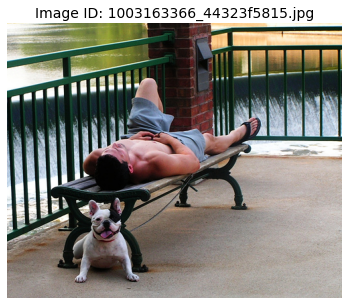

Image Shape: (410, 500, 3)

Captions for the Image ID "1003163366_44323f5815.jpg":
1. A man lays on a bench while his dog sits by him .
2. A man lays on the bench to which a white dog is also tied .
3. a man sleeping on a bench outside with a white and black dog sitting next to him .
4. A shirtless man lies on a park bench with his dog .
5. man laying on bench holding leash of dog sitting on ground




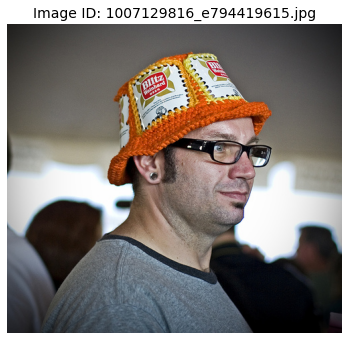

Image Shape: (461, 500, 3)

Captions for the Image ID "1007129816_e794419615.jpg":
1. A man in an orange hat starring at something .
2. A man wears an orange hat and glasses .
3. A man with gauges and glasses is wearing a Blitz hat .
4. A man with glasses is wearing a beer can crocheted hat .
5. The man with pierced ears is wearing glasses and an orange hat .




In [4]:
# Visualise both the images & text present in the dataset for the first five unique images

# Get first 5 unique image IDs
unique_image_ids = image_captions_df['image'].unique()[:5]

# Loop through each unique image
for image_id in unique_image_ids:
    # Read and display the image
    image_path = images_path + image_id
    image = plt.imread(image_path)
    
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image ID: {image_id}', fontsize=14)
    plt.show()
    
    print(f'Image Shape: {image.shape}\n')
    
    # Get all the captions for this image
    captions = image_captions_df[image_captions_df['image'] == image_id]['caption'].values
    print(f'Captions for the Image ID "{image_id}":')
    for idx, caption in enumerate(captions,1):
        print(f'{idx}. {caption}')
    
    print('\n' + '='*80 + '\n')

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [5]:
all_img_id=[]#store all the image id here
all_img_vector= []#store all the image path here
annotations= []#store all the captions here

with open(captions_path, 'r') as fo:
    next(fo) # to skip heading
    for line in fo:
        split_arr = line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.')) # stripping \n and fullstop
        all_img_vector.append(images_path + split_arr[0])
    
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way
1,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building
2,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin
...,...,...,...
40450,997722733_0cb5439472.jpg,datasets/flickr/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,datasets/flickr/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air
40452,997722733_0cb5439472.jpg,datasets/flickr/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles
40453,997722733_0cb5439472.jpg,datasets/flickr/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt


In [6]:
# Create the vocabulary & the counter for the captions
# Tokenize and build vocabulary
vocabulary = [word.lower() for line in annotations for word in line.split()]

# Count word frequencies
val_count = Counter(vocabulary)

# View top 30 most common words
top_30 = val_count.most_common(30)
print(top_30)

[('a', 60196), ('in', 18174), ('the', 17507), ('on', 10357), ('is', 9069), ('and', 8057), ('dog', 7948), ('with', 7304), ('man', 7137), ('of', 6495), ('two', 5132), ('white', 3706), ('black', 3620), ('boy', 3514), ('are', 3365), ('woman', 3304), ('girl', 3277), ('to', 3005), ('wearing', 2916), ('people', 2811), ('at', 2810), ('water', 2676), ('young', 2587), ('red', 2553), ('brown', 2457), ('an', 2325), ('his', 2255), ('blue', 2125), ('dogs', 2095), ('running', 1996)]


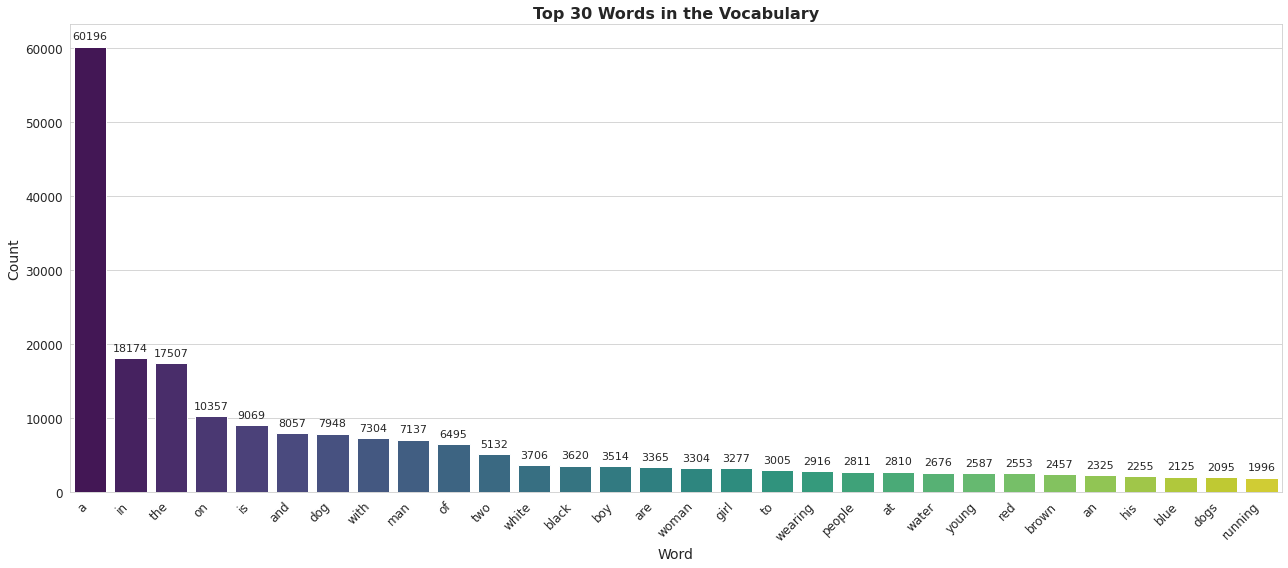

In [7]:
# Visualise the top 30 occuring words in the captions
# Extracting top 30 most common words and their counts
top30 = val_count.most_common(30)
words, counts = zip(*top30)

# Plotting
plt.figure(figsize=(18,8))
sns.set_style("whitegrid")
plot = sns.barplot(x=list(words), y=list(counts), palette='viridis')

# Setting title and labels
plt.title('Top 30 Words in the Vocabulary', fontsize=16, weight='bold')
plt.xlabel('Word', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Annotate each bar with its count
for bar in plot.patches:
    height = int(bar.get_height())
    plot.annotate(f'{height}',
                 (bar.get_x() + bar.get_width() / 2. , height),
                 ha='center', va='bottom',
                 xytext=(0,5),
                 textcoords='offset points',
                 fontsize=11)
    
plt.tight_layout()
plt.show()

In [8]:
# Pre‐compute translation table once
rem_punct = str.maketrans('', '', string.punctuation)

def clean_caption(caption: str) -> str:
    
    # Lowercase & strip punctuation
    s = caption.lower().translate(rem_punct)
    
    # Split into tokens
    tokens = s.split()
    
    # Keep only alphabetic tokens longer than 1 character
    tokens = [t for t in tokens if t.isalpha() and len(t) > 1]
    
    # Rejoin
    return ' '.join(tokens)

# Apply to all annotations
annotations = [clean_caption(line) for line in annotations]

In [9]:
#Create a list which contains all the captions
annotations= ['<start>' + ' ' + line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path = all_img_vector

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [10]:
# create the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(
                num_words = 5001,
                filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                lower = True,
                char_level = False,
                split = " ", 
                oov_token='UNK')
tokenizer.fit_on_texts(annotations)
caption_seqs = tokenizer.texts_to_sequences(annotations)

In [11]:
# Create word-to-index and index-to-word mappings.
word_index = tokenizer.word_index
index_word = tokenizer.index_word

In [12]:
# Adding padding index to tokenizer
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

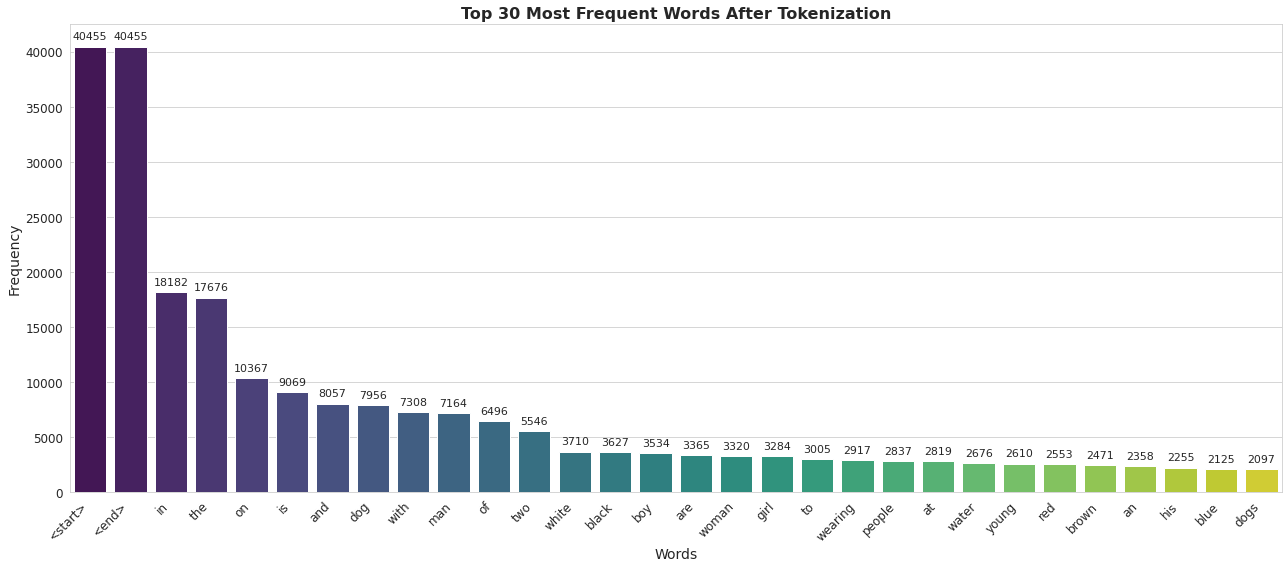

In [13]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
word_counts = tokenizer.word_counts

# Get top 30 most common words
top_30 = Counter(word_counts).most_common(30)
words, counts = zip(*top_30)

# Plotting
plt.figure(figsize=(18, 8))
sns.set_style("whitegrid")
plot = sns.barplot(x=list(words), y=list(counts), palette='viridis')

# Title and labels
plt.title('Top 30 Most Frequent Words After Tokenization', fontsize=16, weight='bold')
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Annotate bars
for bar in plot.patches:
    count = int(bar.get_height())
    plot.annotate(f'{count}',
                  (bar.get_x() + bar.get_width() / 2., count),
                  ha='center', va='bottom',
                  xytext=(0, 5),
                  textcoords='offset points',
                  fontsize=11)

plt.tight_layout()
plt.show()

In [14]:
# Pad each vector to the max_length of the captions and store it to a variable
max_length = max(len(seq) for seq in caption_seqs)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(caption_seqs, 
                                                          maxlen=max_length, 
                                                          padding='post',
                                                          dtype='int32', 
                                                          value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 31)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.

In [15]:
#write your code here for creating the function. This function should return images & their path
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [16]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

# Get unique image paths
unique_img_vector = sorted(set(all_img_vector))

# Create tf.data.Dataset from the image paths
image_dataset = (
    tf.data.Dataset.from_tensor_slices(unique_img_vector)
    .map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    .batch(64)
)
image_dataset

2025-06-23 04:18:15.815175: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-06-23 04:18:15.815244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22666 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5


<BatchDataset shapes: ((None, 299, 299, None), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)

In [17]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [18]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
# Directory to save features
save_feature_dir = 'features'
os.makedirs(save_feature_dir, exist_ok=True)

for batch_images, batch_paths in tqdm(image_dataset, desc="Extracting & saving features"):
    # Extract features
    batch_features = image_features_extract_model(batch_images)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[-1]))

    for feature, path_tensor in zip(batch_features, batch_paths):
        # Decode image path
        original_path = path_tensor.numpy().decode("utf-8")
        # Get base filename without extension
        file_name = os.path.basename(original_path).split('.')[0]
        # New path to save .npy file
        feature_path = os.path.join(save_feature_dir, file_name + '.npy')

        # Save the feature
        np.save(feature_path, feature.numpy())

Extracting & saving features: 100%|██████████| 127/127 [00:26<00:00,  4.74it/s]


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [19]:
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [20]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [21]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image, caption):
    # Decode byte string to regular string
    image_path = image.decode("utf-8")

    # Extract base filename without extension
    filename = os.path.splitext(os.path.basename(image_path))[0]

    # Load the corresponding .npy file from the 'features/' directory
    feature_path = f'features/{filename}.npy'
    img_tensor = np.load(feature_path)

    return img_tensor, caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [22]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(image, caption,batch_size = 64,buffer_size=1000):

    dataset = tf.data.Dataset.from_tensor_slices((image, caption))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle and batch
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [23]:
BATCH_SIZE = 64

train_dataset=gen_dataset(path_train,cap_train,BATCH_SIZE)
test_dataset=gen_dataset(path_test,cap_test,BATCH_SIZE)

In [24]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 31)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [25]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Encoder

In [26]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        #It acts as the fully connected layer
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [27]:
encoder = Encoder(embedding_dim)

### Attention model

In [28]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =  tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis=hidden[:, tf.newaxis] # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        # the tensor is reduced along the second dimension (columns)

        return context_vector, attention_weights

### Decoder

In [29]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)   #build your Dense layer

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [30]:
decoder = Decoder(embedding_dim, units, vocab_size)

In [31]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [32]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define your loss object

In [33]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [34]:
checkpoint_path = "/checkpoint"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [35]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [36]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation for implementing backpropagation
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions)

          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1])) #we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    
    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables)) 
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [37]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    encoder_output = encoder(img_tensor)

    for t in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)
        loss += loss_function(target[:, t], predictions)
        dec_input = tf.expand_dims(target[:, t], 1)

    avg_loss = loss / int(target.shape[1])

    return loss, avg_loss

In [38]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [39]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.438, & test loss is 1.220
Time taken for 1 epoch 158.9152204990387 sec

Test loss has been reduced from 100.000 to 1.220


  7%|▋         | 1/15 [02:39<37:12, 159.46s/it]

For epoch: 2, the train loss is 1.133, & test loss is 1.121
Time taken for 1 epoch 50.112361669540405 sec

Test loss has been reduced from 1.220 to 1.121


 13%|█▎        | 2/15 [03:30<20:41, 95.48s/it] 

For epoch: 3, the train loss is 1.025, & test loss is 1.077
Time taken for 1 epoch 49.449326038360596 sec

Test loss has been reduced from 1.121 to 1.077


 20%|██        | 3/15 [04:20<14:57, 74.75s/it]

For epoch: 4, the train loss is 0.951, & test loss is 1.055
Time taken for 1 epoch 47.10615158081055 sec

Test loss has been reduced from 1.077 to 1.055


 27%|██▋       | 4/15 [05:07<11:44, 64.06s/it]

For epoch: 5, the train loss is 0.889, & test loss is 1.052
Time taken for 1 epoch 47.63916301727295 sec

Test loss has been reduced from 1.055 to 1.052


 40%|████      | 6/15 [06:46<08:20, 55.61s/it]

For epoch: 6, the train loss is 0.834, & test loss is 1.066
Time taken for 1 epoch 50.10074496269226 sec



 47%|████▋     | 7/15 [07:32<07:00, 52.59s/it]

For epoch: 7, the train loss is 0.783, & test loss is 1.069
Time taken for 1 epoch 46.37091612815857 sec



 53%|█████▎    | 8/15 [08:20<05:56, 50.95s/it]

For epoch: 8, the train loss is 0.737, & test loss is 1.090
Time taken for 1 epoch 47.443652629852295 sec



 60%|██████    | 9/15 [09:07<04:59, 49.91s/it]

For epoch: 9, the train loss is 0.692, & test loss is 1.111
Time taken for 1 epoch 47.623255252838135 sec



 67%|██████▋   | 10/15 [09:55<04:06, 49.26s/it]

For epoch: 10, the train loss is 0.650, & test loss is 1.148
Time taken for 1 epoch 47.798789978027344 sec



 73%|███████▎  | 11/15 [10:46<03:18, 49.67s/it]

For epoch: 11, the train loss is 0.611, & test loss is 1.172
Time taken for 1 epoch 50.57787108421326 sec



 80%|████████  | 12/15 [11:33<02:26, 48.94s/it]

For epoch: 12, the train loss is 0.575, & test loss is 1.210
Time taken for 1 epoch 47.27773904800415 sec



 87%|████████▋ | 13/15 [12:21<01:37, 48.64s/it]

For epoch: 13, the train loss is 0.542, & test loss is 1.243
Time taken for 1 epoch 47.94687366485596 sec



 93%|█████████▎| 14/15 [13:07<00:47, 47.97s/it]

For epoch: 14, the train loss is 0.510, & test loss is 1.277
Time taken for 1 epoch 46.40451765060425 sec



100%|██████████| 15/15 [13:54<00:00, 55.67s/it]

For epoch: 15, the train loss is 0.480, & test loss is 1.330
Time taken for 1 epoch 46.999191999435425 sec



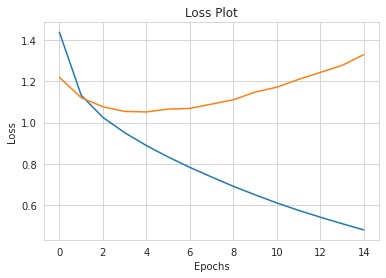

In [40]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [41]:
attention_features_shape = 64
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [42]:
def plot_attmap(caption, weights, image_path):
    fig = plt.figure(figsize=(12, 12))
    temp_img = np.array(Image.open(image_path))

    len_cap = len(caption)
    
    # Dynamically calculate rows and columns to fit all subplots
    cols = int(math.ceil(math.sqrt(len_cap)))
    rows = int(math.ceil(len_cap / cols))

    for cap in range(len_cap):
        # Ensure attention weights are reshaped correctly
        weights_img = np.reshape(weights[cap], (8, 8))  # assumes 64-dim attention
        weights_img = np.array(Image.fromarray(weights_img).resize(
            (temp_img.shape[1], temp_img.shape[0]), Image.LANCZOS))

        ax = fig.add_subplot(rows, cols, cap + 1)
        ax.set_title(caption[cap], fontsize=12)

        img = ax.imshow(temp_img)
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6, extent=img.get_extent())
        ax.axis('off')

    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

In [43]:
from nltk.translate.bleu_score import sentence_bleu

In [44]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [45]:
def pred_caption_audio(weights) :

    rid = np.random.randint(0, len(path_test))
    test_image = path_test[rid]

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)


    real_caption=filt_text(real_caption)      


    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights)#set your weights
    print(f"BELU score: {score*100}")
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)

    # Convert the predicted caption to speech using Google Text-to-Speech (gTTS) and play the audio output
    speech = gTTS("Predicted Caption is: "+ pred_caption,lang = 'en', slow = False) 
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'
    display(Audio('voice.mp3'))

    return test_image

BELU score: 15.159143965003283
Real Caption: one man wearing black hoodie sweatshirt and another wearing box over his head
Prediction Caption: an old man in black hat is standing next to him


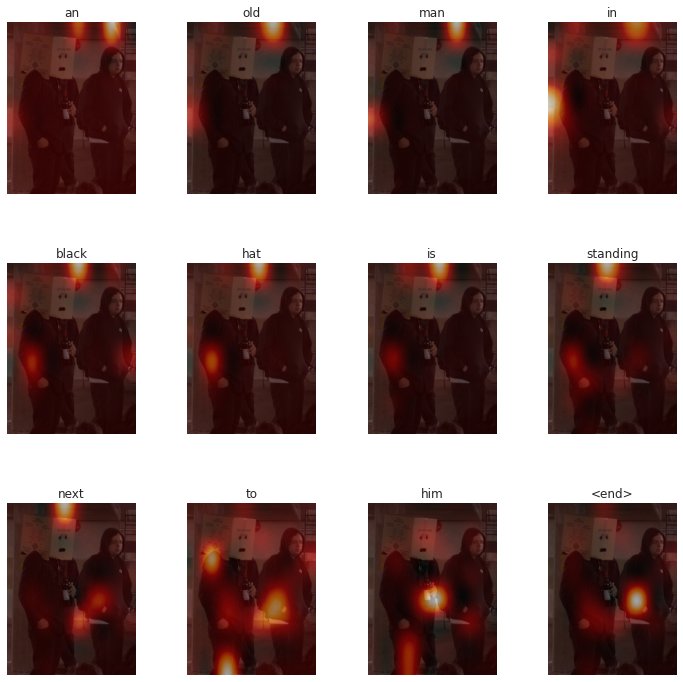

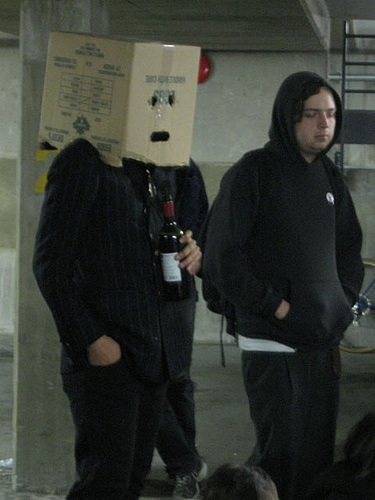

In [50]:
test_image = pred_caption_audio(weights = (1, 0, 0, 0))
Image.open(test_image)

BELU score: 8.20849986238988
Real Caption: three children in field with white flowers
Prediction Caption: three children


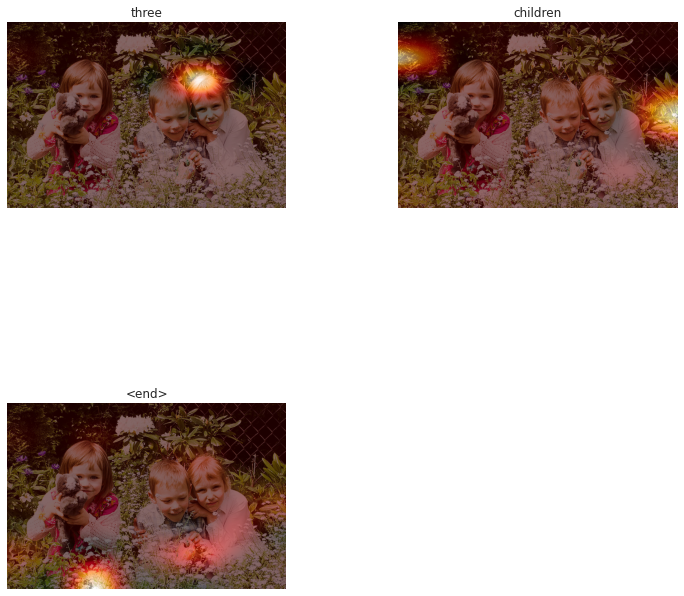

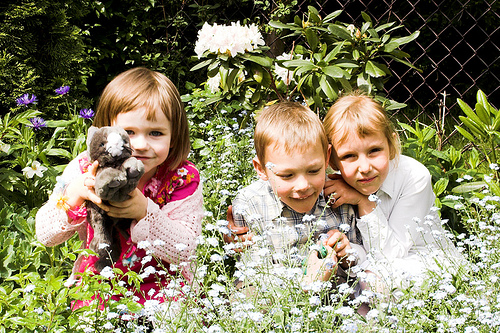

In [54]:
test_image = pred_caption_audio(weights = (0.5, 0.5, 0, 0))
Image.open(test_image)